<h1><center><font>Bank Default Problem using Advanced Feature Engineering and Feature Selection</font></center></h1>

By -
- Avinash Matani

# <a>Table of Contents</a>

- <a>Introduction</a>  
- <a>Import Packages</a>  
- <a>Load Dataset</a>  
    - <a>Data exploration</a>
- <a>Data Preparation for Modelling</a>  
    - <a>Outlier Treatment</a> 
    - <a>Encoding Caterical Features</a>
- <a>Feature Engineering</a>  
    - <a>Train and Test Split</a> 
    - <a>Feature Scaling</a>
- <a>Data Modelling</a>
    - <a>KNN</a>
    - <a>Naive Bayes</a>
    - <a>Decision Tree</a>
    - <a>SVM</a>
    - <a>Random Forest</a>
- <a>Model Performance Comparison</a>
- <a>Limitations</a>
- <a>Conclusion</a>
- <a>References</a>

# <a>Introduction</a>

The report is aimed at comparing different classification models to predict whether the credit card customers in Taiwan will default in the next month using a piece of financial information such as credit card statement, customer's credit limit, repayment status etc. The data contained this information is sourced from 1994 UCI Machine Learning Repository and is based on the payment date of October 2005 issued by a major bank in Taiwan. The dataset includes 11 categorical features and 13 numerical features (including customer ID) with about 30,000 observations. The target feature is Default Status of the customers in October 2005 and is categorized into two levels Default and No-Default.

# Overview

The report includes analysis, interpretation, description and performance comparison of five classification models to predict the target feature -

* K-Nearest Neighbors (KNN),
* Naive Bayes (NB)
* Decision trees (DT),
* Support Vector Machine (SVM), and
* Random Forest Classifier (RFC)

The overall report is segmented into five major stages. The first stage is data cleaning during which the features were checked for validity, completeness, consistency, uniqueness, and accuracy of data points. 

The second stage is data exploration where all the features were explored to seek patterns, characteristics and major points of interest. 

The third stage is Data Preparation where the data is prepared for specific machine learning algorithms. This involves treating outliers identified during data exploration and encoding categorical features. 

The fourth stage is feature engineering which is one of the most important steps in data science model building process. This includes the selection of relevant features which makes machine learning algorithm train faster, reduces model complexity, and enhance model accuracy if the appropriate features are chosen. For this application, we have used Random Forest Feature Importance method in sklearn. 

The fifth stage is comprised of the model building strategy where we will use the cross-validation technique, tune the parameter values, transform dataset as required, compare different models and report the final model selected. 

## Methodology

Our model building strategy is comprised of feature engineering where we will combine the information from a several features to build relevant features aimed at increasing the accuracy. We will then divide the dataset into train (70% of the dataset) and test sets (30% of the data).

* 70% i.e. 21,000 observations will be used for training and hyper parameter tuning
* 30% i.e. 9,000 observations will be used to test and compare the performance of the models

The training and test data set are scaled separately to bring the numerical values in the common scale without compromising the difference among the range of values. The feature selection technique based on Random Forest Importance method is used to select the best features for the models. Further, hyperparameter tuning based on grid search CV method along with the feature selection method is used in the single pipeline to select the combination of best features and parameter of the classifier.

We have used stratified cross-validation strategy with 5 folds considering a set of best 5, 10, 20 and all variables from Random Forest Importance to fine-tune the hyperparameters and optimize F1 score of each of the classifiers. Since the target feature contains defaulters and non-defaulters in 20:80 ratio respectively, stratification is necessary to ensure a similar ratio of target features contained in the original dataset. 

To fasten the parameter tuning process, parallel processing with '-2' cores is used. During the parameter tuning process, each of the classifiers is assessed on the mean f1 score obtained on the test data and models were further fine-tuned to select the best parameter values. 

While scaling is performed for all the classifiers, power transformation is performed only for the Naive Bayes algorithm. Finally, each of the models obtained is evaluated against the sample test data using 10 fold cross-validation strategy and best estimator obtained from the parameter tuning process. To compare the performance of the models using optimized F1 score, a paired t-test was performed with 0.05% significance level.  

# <a>Import Packages</a>

The required packages were imported and seed value is selected to ensure reproducibility of the results at a later stage.  

In [1]:

import warnings
warnings.filterwarnings("ignore") # Turning off the warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
import altair as alt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from IPython.display import display, HTML
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from numpy import argsort
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from scipy import stats
alt.renderers.enable('notebook')
pd.set_option('display.max_columns', None)

# Setting random states

seed_value = 999 

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

# <a>Load Dataset</a>

The dataset is loaded from the drectory. 

In [2]:
dataset = 'credit_default.csv'
src_df = pd.read_csv(dataset, header = 1)

src_df.reset_index(drop=True,inplace=True)
src_df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## <a>Data Review</a>

We start by looking at the dimensions of the dataset.

In [3]:
src_df.shape

(30000, 25)

The dataset is comprised of 30000 observations and 24 descriptive features with 'default payment next month' as the target feature. 

# <a>Data Cleaning</a>

### Removing Unecessary Columns

Columns with unique values in the dataset such as ID are removed as they possess no variation as a predictor variable and are therefore useless for modelling purpose. 

In [4]:
# Removing unncecessary columns
df= src_df.drop("ID",axis=1)
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## <a>Rename Columns</a>

The columns names are renamed to make columns more intutive.

In [5]:
df = df.rename(columns={'default payment next month': 'nxt_mnth_default'})
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,nxt_mnth_default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## <a>Check data types</a>

The datatypes are checked against the data description file.

In [6]:
print(f"Shape of the dataset is {df.shape} \n")
print(f"Data types are below where 'object' indicates a string type: ")
print(df.dtypes)

Shape of the dataset is (30000, 24) 

Data types are below where 'object' indicates a string type: 
LIMIT_BAL           int64
SEX                 int64
EDUCATION           int64
MARRIAGE            int64
AGE                 int64
PAY_0               int64
PAY_2               int64
PAY_3               int64
PAY_4               int64
PAY_5               int64
PAY_6               int64
BILL_AMT1           int64
BILL_AMT2           int64
BILL_AMT3           int64
BILL_AMT4           int64
BILL_AMT5           int64
BILL_AMT6           int64
PAY_AMT1            int64
PAY_AMT2            int64
PAY_AMT3            int64
PAY_AMT4            int64
PAY_AMT5            int64
PAY_AMT6            int64
nxt_mnth_default    int64
dtype: object


## <a>Check Missing Values</a>


In [7]:
print(f"\nNumber of missing values for each feature:")
print(df.isnull().sum())


Number of missing values for each feature:
LIMIT_BAL           0
SEX                 0
EDUCATION           0
MARRIAGE            0
AGE                 0
PAY_0               0
PAY_2               0
PAY_3               0
PAY_4               0
PAY_5               0
PAY_6               0
BILL_AMT1           0
BILL_AMT2           0
BILL_AMT3           0
BILL_AMT4           0
BILL_AMT5           0
BILL_AMT6           0
PAY_AMT1            0
PAY_AMT2            0
PAY_AMT3            0
PAY_AMT4            0
PAY_AMT5            0
PAY_AMT6            0
nxt_mnth_default    0
dtype: int64


The dataset has no missing values .

## <a>Check data summary</a>

This section is comprised of checking summary of the data before the analysis to better understand the categorical and continuous features in the dataset.

### Continuous Features

In [8]:
## Summary of continuous features

display(HTML('<b>Table 1: Summary of continuous features</b>'))
df.describe(include='int64').round(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,nxt_mnth_default
count,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000,30000.00,30000.000,30000.000,30000.000,30000.000,30000.000,30000.000
mean,167484.323,1.604,1.853,1.552,35.486,-0.017,-0.134,-0.166,-0.221,-0.266,-0.291,51223.331,49179.075,47013.155,43262.949,40311.401,38871.760,5663.58,5921.164,5225.682,4826.077,4799.388,5215.503,0.221
std,129747.662,0.489,0.790,0.522,9.218,1.124,1.197,1.197,1.169,1.133,1.150,73635.861,71173.769,69349.387,64332.856,60797.156,59554.108,16563.28,23040.870,17606.961,15666.160,15278.306,17777.466,0.415
min,10000.000,1.000,0.000,0.000,21.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-165580.000,-69777.000,-157264.000,-170000.000,-81334.000,-339603.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
25%,50000.000,1.000,1.000,1.000,28.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,3558.750,2984.750,2666.250,2326.750,1763.000,1256.000,1000.00,833.000,390.000,296.000,252.500,117.750,0.000
50%,140000.000,2.000,2.000,2.000,34.000,0.000,0.000,0.000,0.000,0.000,0.000,22381.500,21200.000,20088.500,19052.000,18104.500,17071.000,2100.00,2009.000,1800.000,1500.000,1500.000,1500.000,0.000
75%,240000.000,2.000,2.000,2.000,41.000,0.000,0.000,0.000,0.000,0.000,0.000,67091.000,64006.250,60164.750,54506.000,50190.500,49198.250,5006.00,5000.000,4505.000,4013.250,4031.500,4000.000,0.000
max,1000000.000,2.000,6.000,3.000,79.000,8.000,8.000,8.000,8.000,8.000,8.000,964511.000,983931.000,1664089.000,891586.000,927171.000,961664.000,873552.00,1684259.000,896040.000,621000.000,426529.000,528666.000,1.000


### Categorical Features

In [9]:
cat_colms = ['SEX','EDUCATION', 'MARRIAGE','nxt_mnth_default']

In [10]:
print(df['SEX'].value_counts())
print(df['EDUCATION'].value_counts())
print(df['MARRIAGE'].value_counts())
print(df['nxt_mnth_default'].value_counts())

2    18112
1    11888
Name: SEX, dtype: int64
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64
2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64
0    23364
1     6636
Name: nxt_mnth_default, dtype: int64


# <a>Data Exploration</a>

Here the data is explored to understand the relationship among different features. During this stage, we are aimed at bringing important characteristics of the data into consideration for further analysis. 

## <a>Univariate Data Exploration</a>

#### Distribution of Target Class 
Figure 1: represents that 20% of customers have defaulted whereas around 80% have not. This is a typical case of class imbalance. While modelling we need to make sure we do appropriate re-sampling to handle the class imbalance. 

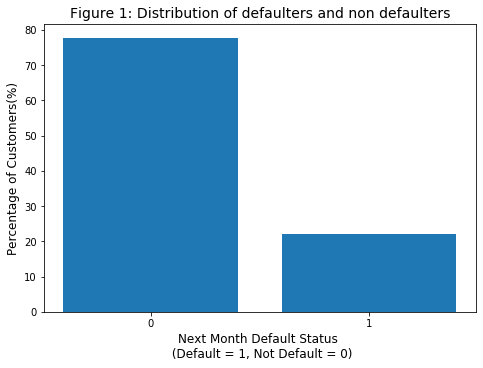

In [11]:
fig= plt.figure()
ax=fig.add_axes([0,0,1,1])
val=df["nxt_mnth_default"].value_counts()/df.shape[0]
val=val*100
idx=list(map(str,val.index))
ax.bar(idx,val)
ax.set_ylabel("Percentage of Customers(%)", fontsize = 12)
plt.xlabel('Next Month Default Status \n (Default = 1, Not Default = 0)', fontsize = 12)
ax.set_title("Figure 1: Distribution of defaulters and non defaulters", fontsize = 14)
plt.show()

#### Distribution of Credit Balance Limit (LIMIT_BAL)

Figure 2: represents that credit limit balance is right-skewed. This indicates that the majority of customers lie in lower balance limit and number of customers become lesser as a move towards higher credit balance limit.

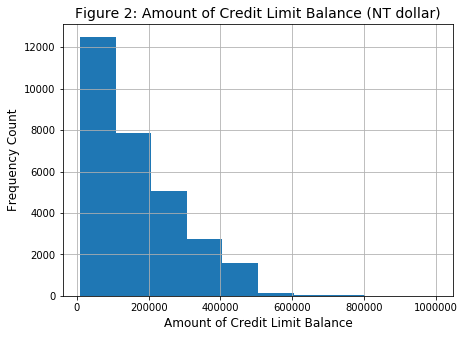

In [12]:
plt.figure(figsize = (7,5))
plt.title("Figure 2: Amount of Credit Limit Balance (NT dollar)", fontsize = 14)
df["LIMIT_BAL"].hist()
plt.xlabel("Amount of Credit Limit Balance", fontsize = 12)
plt.ylabel("Frequency Count", fontsize = 12)
plt.show();

#### Distribution of Age 
Figure 3: indicates that the age range starts from a value above 20 which could be the eligibility age and goes up to 80. Anyhow customer above 60 seems to be rare cases. The third quartile is just slightly above 40 which suggests age, 75% customer are below it. Further, the shape of box-plot suggest that the age distribution is rightly skewed. 

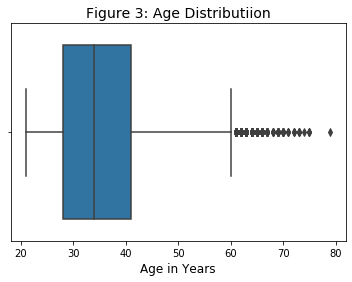

In [13]:
sns.boxplot(df['AGE']).set_title('Figure 3: Age Distributiion', fontsize = 14)
plt.xlabel("Age in Years", fontsize = 12)
plt.show();

## <a>Bivariate Data Exploration</a>

#### Probability Plot function
The probabilty function is defined to understand the relationship among different features. 

In [14]:
def prob_plot(by_col,xlab,colmn, figno):
    fig= plt.figure()
    ax=fig.add_axes([0,0,1,1])
    dflt=df.groupby(by_col)['nxt_mnth_default'].agg(['sum','count'])
    dflt["Prob_Dflt"]=dflt["sum"]/dflt["count"]
    dflt["Prob_Dflt"]=dflt["Prob_Dflt"]
    idx=list(map(str,dflt.index))
    ax.bar(idx,dflt["Prob_Dflt"])
    ax.set_ylabel("Probability of defaulting", fontsize = 12)
    ax.set_xlabel(xlab, fontsize = 12)
    ax.set_title(f"Figure {figno}: Probability of defaulting by {colmn}", fontsize = 14)
    plt.show()

#### Probability of defaulting by Sex

Figure 4: indiactes the probability of being a default by male and female. The probabilty of being a default is slightly higher for male over female.

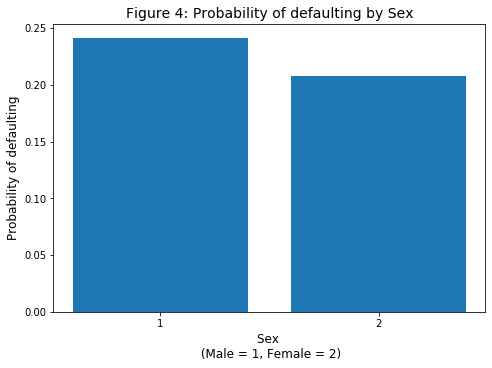

In [15]:
prob_plot("SEX","Sex \n (Male = 1, Female = 2)","Sex", 4)

#### Probability of defaulting by Education
Figure 5: indicates the probability of default based on education level. Clients belonging to university and high school is identified to posses higher probability of default over clients in others and unknown category. Thus, clients belonging to others and unknown category is also an interesting area to explore.  

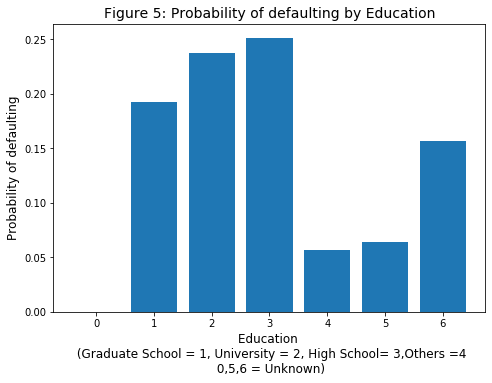

In [16]:
prob_plot("EDUCATION","Education \n (Graduate School = 1, University = 2, High School= 3,Others =4\n 0,5,6 = Unknown)","Education" , 5)

#### Defaulting behaviour by Balance Limit (LIMIT_BAL)
Figure 6: indicates the probability distribution of default status based on credit limit balance. It shows that clients belonging to range of 10K to 50K credit limit balance posses largest probability of being a defaulter as indicated by the red curve. 

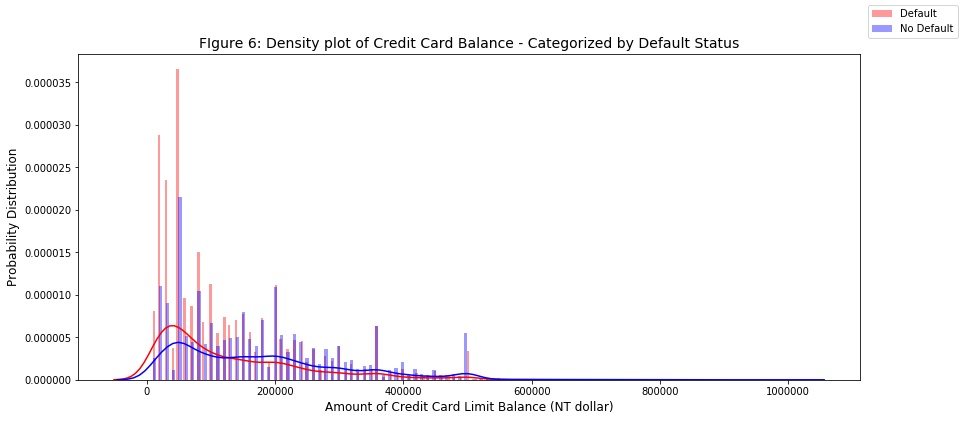

In [17]:
N_Default = df.loc[df['nxt_mnth_default'] == 0]["LIMIT_BAL"]
Default = df.loc[df['nxt_mnth_default'] == 1]["LIMIT_BAL"]
fig = plt.figure(figsize = (14,6))
plt.title('FIgure 6: Density plot of Credit Card Balance - Categorized by Default Status', fontsize = 14)
sns.set_color_codes("pastel")
sns.distplot(Default,kde=True,bins=200, color="red")
sns.distplot(N_Default,kde=True,bins=200, color="blue")
plt.xlabel("Amount of Credit Card Limit Balance (NT dollar)", fontsize = 12)
plt.ylabel("Probability Distribution", fontsize = 12)
fig.legend(labels=['Default','No Default'], loc = 'upper right' )
plt.show()

## <a>Multivariate Data Exploration</a>

#### Defaulters by Balance Limit and Age
Figure 7: does not show a strong pattern in terms of credit card balance distribution and age. However, it shows that majority of defaulters are concentrated towards lower Balance Limit and age above 40.

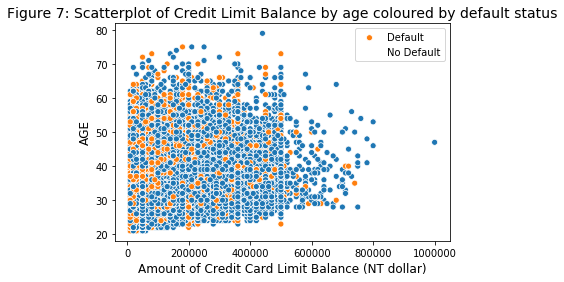

In [18]:
sns.scatterplot(df['LIMIT_BAL'], df['AGE'], hue = df['nxt_mnth_default'])
plt.title('Figure 7: Scatterplot of Credit Limit Balance by age coloured by default status', fontsize = 14);
plt.legend(labels = ['Default', 'No Default'], loc = 'upper right')
plt.xlabel("Amount of Credit Card Limit Balance (NT dollar)", fontsize = 12)
plt.ylabel("AGE", fontsize = 12)
plt.show();

#### Probability of defaulting by Sex and Martial Status
Figure 8: indicates that probability of defaulting varies greatly with client's gender and martial status. Male belonging to others category (could be divorced) and married seems to have higher probability of being a defaulter over single female or married female.

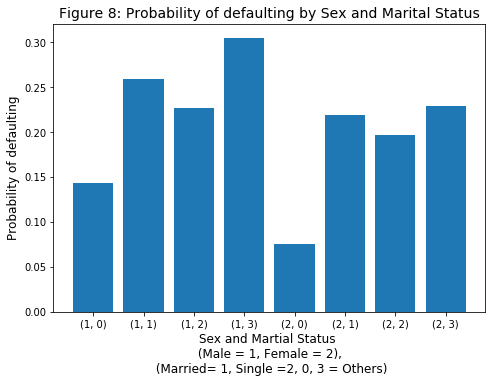

In [19]:
dflt=df.groupby(["SEX","MARRIAGE"])['nxt_mnth_default'].agg(['sum','count'])

prob_plot(["SEX","MARRIAGE"], "Sex and Martial Status \n (Male = 1, Female = 2), \n (Married= 1, Single =2, 0, 3 = Others)", "Sex and Marital Status", 8)


#### Credit Card Limit Distribution by Education and Marital Status
Figure 9: indicates that credit card limit is significantly higher among clients who are married and has some graduate degree followed by customers who are graduate and single. This indicates that higher credit limit balance is dependent more on education.  

In [20]:
df2 = df[(df.EDUCATION != 0) & (df.EDUCATION != 5) & (df.EDUCATION != 6)]
def boxplot_relation(col1, col2, col3, width=15):
    fig, ax2 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax2, x=col1, y=col2, hue=col3,
                data=df2, palette="PRGn",showfliers=False)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.title('Figure 9: Boxplot of Credit Limit Balance by Education and Marital Status', fontsize = 14);
    plt.legend(labels = ['Graduate School', 'University', 'High School', 'Others'],loc = 'upper right')
    plt.xlabel("Marital Status \n (Married = 1, Single = 2, 0,3 = Others)", fontsize = 12)
    plt.ylabel("Credit Limit Balance (NT Dollar)", fontsize = 12);
    plt.show();

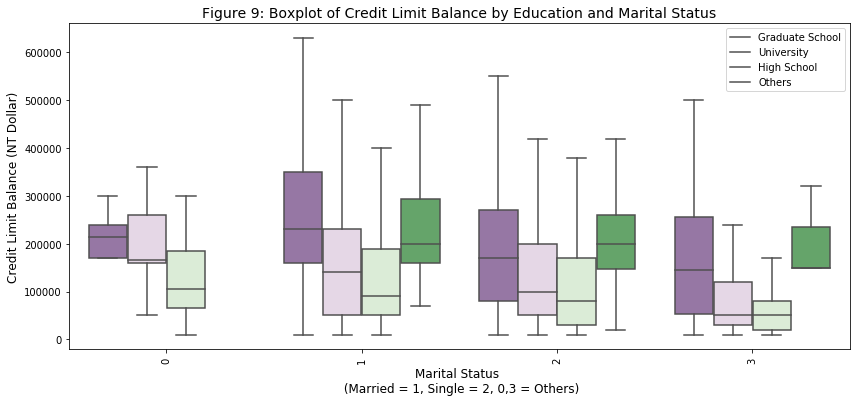

In [21]:
boxplot_relation('MARRIAGE','LIMIT_BAL', 'EDUCATION',14)

# <a>Data Preparation for Modelling</a>

## <a>Outlier Treatment</a>
### Age
During data exploration, the age ditribution shows presence of some outliers. We will handle by using capping technique where we will replace the outlier in lower range by min value and outliers in higher range by max value in the age column. 

In [22]:
numeric_cols=["AGE"]

quantiles=df[numeric_cols].quantile([0.25,0.75],axis=0)

for i in numeric_cols:
    q1,q3= quantiles[i]
    iqr= q3-q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr) 
    df.loc[(df[i]<lower_bound) | (df[i]>upper_bound),i]=np.nan
    

df=df[~df["AGE"].isnull()]

## <a>Encoding Categorical Features</a>

Before modelling, it is necessary to encode both target and descriptive features into numercial features. 
### Marriage
Marriage Column is has values as 0,1,2,3. Data description indicates 1 = married; 2 = single; 3 = others (0 has no description but lets assume its one of a type). This does not seem like ordinal data hence will use one hot encoding technique for these types of variables.

We will use pandas inbuilt get dummies function and use simple one hot encoding for variable more than two levels i.e. we will define more than q dummy variables for q levels (q>2). 

In [23]:
df["MARRIAGE"]=df["MARRIAGE"].astype('category')
dummy_marriage=pd.get_dummies(df["MARRIAGE"])
dummy_marriage=dummy_marriage.add_prefix("MARRIAGE_")
df=pd.concat([dummy_marriage,df],axis=1)
df=df.drop(labels=["MARRIAGE"],axis=1)

### Encoding Gender

Gender also being a nominal categorical is one hot encoded. Since the gender variable has only 2 levels we will set the drop first option as True to create a single column of 0 and 1. 

In [24]:
df["SEX"]=df["SEX"].astype('category')
dummy_sex=pd.get_dummies(df["SEX"],drop_first=True)
dummy_sex=dummy_sex.add_prefix("SEX_")
df=pd.concat([dummy_sex,df],axis=1)
df=df.drop(labels=["SEX"],axis=1)

Our dataset already represents positive class (default) as 1. Thus, it is not necessary to encode the target feature. 

# <a>Feature Engineering</a>
We create new features Bill total for 6 months as BILL_TOT and Pay total for 6 months as PAY_TOT. Further, we calculate ratio of PAY_TOT and BILL_TOT as PAY_BILL_RATIO. Exploring mean values is reasonable as defaulters are identified to possess lower payement ratio than non defaulters.

In [25]:
df["BILL_TOT"]=df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4','BILL_AMT5', 'BILL_AMT6']].sum(axis=1)

df["PAY_TOT"]=df[[ 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)

df["PAY_BILL_RATIO"]=df["PAY_TOT"]/df["BILL_TOT"]

# Where Bill is 0 we might get NAN value so we replace 0/0 or any value by 0 as 1 which indicates full payment.
df.loc[df["BILL_TOT"]==0,"PAY_BILL_RATIO"]=1

df.groupby("nxt_mnth_default")["PAY_BILL_RATIO"].mean().round(3)

nxt_mnth_default
0    0.451
1    0.259
Name: PAY_BILL_RATIO, dtype: float64

## <a>Train and Test Split</a>
We will separate the descriptive and target features. Since our dataset has 30k observations, we will will work only with a small subset of dataset: 5000 observations sampled randomly.  

In [26]:
Data=df.drop(labels=["nxt_mnth_default"],axis=1)
target= df["nxt_mnth_default"]

n_samples = 5000

Data_sample = pd.DataFrame(Data).sample(n=n_samples, random_state=999).values
target_sample = pd.DataFrame(target).sample(n=n_samples, random_state=999).values

We will bifurcate randomly sampled dataset into training and test dataset into 70:30 ratio using target stratification for model training and evaluation.  

In [27]:
Data_sample_train, Data_sample_test, \
target_sample_train, target_sample_test = train_test_split(Data_sample, target_sample, 
                                                    test_size = 0.3, random_state=999,
                                                    stratify = target_sample)
print(Data_sample_train.shape)
print(Data_sample_test.shape)

(3500, 29)
(1500, 29)


## <a>Feature Scaling</a>
After encoding, we will separately scale train and target features to ensure that no information of test data is shared with the model. For this, we will use min-max scaling technique.  

In [28]:
Data_scaler =MinMaxScaler()

Data_scaler.fit(Data_sample_train)

Data_sample_train = Data_scaler.transform(Data_sample_train)
Data_sample_test = Data_scaler.transform(Data_sample_test)

# <a>Data Modelling</a>

## <a>Cross Validation</a>
We have used stratified 5 fold cross validation strategy to train and validate our model. Stratification is necessary to ensure that similar ratio of target feature levels is shared between the training and the target dataset. 

In [29]:
cv_method = StratifiedKFold(n_splits=5, random_state=999)

Data_sample.shape

(5000, 29)

## <a>Feature Selection</a>
We will represent the top 10 features using the random forest feature selector. However, at a later stage we will be using this method in our pipeline during hyperparamter tuning of our classification algorithms.

In [30]:
## Using Random Forest Importance for feature selection

num_features = 10
model_rfi = RandomForestClassifier(n_estimators=100,random_state=999)
model_rfi.fit(Data_sample_train, target_sample_train)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]
best_features_rfi = Data.columns[fs_indices_rfi].values
best_features_rfi

array(['PAY_0', 'PAY_TOT', 'PAY_BILL_RATIO', 'AGE', 'BILL_TOT',
       'LIMIT_BAL', 'PAY_2', 'BILL_AMT1', 'PAY_AMT1', 'BILL_AMT3'],
      dtype=object)

In [31]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.09399621, 0.05685791, 0.04919107, 0.04869169, 0.04744525,
       0.04671581, 0.045636  , 0.04405104, 0.0424076 , 0.04143057])

In [32]:
def plot_imp(best_features, scores, method_name):
    
    df_plot = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    fig= plt.figure()
    ax=fig.add_axes([0,0,1,1])
    idx=best_features
    ax.bar(idx,scores)
    ax.set_ylabel("Importance")
    ax.set_xlabel("Feature")
    
    plt.xticks(rotation=60) 
    ax.set_title(f"{method_name} Feature Importance")
    plt.show()

The random forest importance represented Pay_ToT and Pay_Bill_Ratio as one of top 10 features.

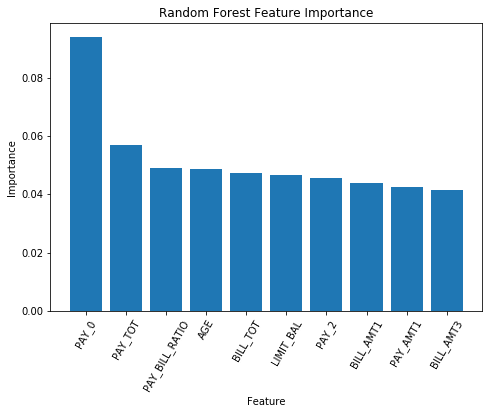

In [33]:
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest')

## <a>Hyperparameter Tuning</a>

#### Creating blank Model Evaluation Dataframe

This will contain the respective score of the models and will represent the selected model based on Score. 

In [34]:
Models_Eval = pd.DataFrame(columns=["Model","Train_F1_Score","Test_F1_Score","Selected"])
Models_Eval

,Model,Train_F1_Score,Test_F1_Score,Selected


#### Feature Selection Function

Here we will utilize this RFI feature selector sourced from (www.featureranking.com) to utilize the RFI selection method in our pipeline for model building 

In [35]:
# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100,random_state=999)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

#### Hyperparameter Tuning Function using either Grid Search or RandomSearch
The function is used to train, test, evaluate model and tune hyperparameter of the classifier. It will assist in training and testing using a grid search CV method and Random search CV method for parameter tuning and is aimed at optimizing F1 score catering towards research problem. 

For Naive bias specifically, the function will perform power transformation of both train and test sampled data. Based on the model type, RFI feature importance criterion, CV strategy and best parameter selected, the function will return the classifier, best parameter selected, selected model evaluation data frame, model performance chart and best estimator values. 

In [36]:
def fit_tune(steps_list,param_dict ,model_name,plt_x_param,plt_x_title,color_plt,color_plt_title,SearchType):
 
    ## Grid and Random Search based on choice
    if(SearchType=="Grid"):
        gs_pipe_model = GridSearchCV(estimator=Pipeline(steps=steps_list), 
                                   param_grid=param_dict, 
                                   cv=cv_method,
                                   refit=True,
                                   n_jobs=-2,
                                   scoring='f1',
                                   verbose=1)
    elif(SearchType=="Random") :
        gs_pipe_model=  RandomizedSearchCV(estimator=Pipeline(steps=steps_list), 
                          param_distributions=param_dict, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='f1',
                          n_iter=20,
                          verbose=1,
                          random_state=999) 
        
    if(model_name=="Naive Bayes"):
        Data_sample_train_transformed = PowerTransformer().fit_transform(Data_sample_train)
        gs_pipe_model.fit(Data_sample_train_transformed, target_sample_train);
    
    else:
        ## Fit the search function to train dataset
        gs_pipe_model.fit(Data_sample_train, target_sample_train);
        
    if(model_name=="Naive Bayes"):
        Data_sample_test_transformed = PowerTransformer().fit_transform(Data_sample_test)
        test_score=gs_pipe_model.score(X=Data_sample_test_transformed, y=target_sample_test)
    
    else:
         ## Get the test F1 Score using fitted function
        test_score=gs_pipe_model.score(X=Data_sample_test, y=target_sample_test)
    
    ## Get results of hyperparameter search in df
    results= get_search_results(gs_pipe_model)
    
    Best_Param=gs_pipe_model.best_params_
    
    #Plot the result
    n_feature=Best_Param["rfi_fs__n_features_"]
    results_best_feature = results[results['rfi_fs__n_features_'] == n_feature]
    
    #Choice based on second parameter of tuning i.e one will be used to plot line other as color
    if (color_plt!=plt_x_param):
        chart = alt.Chart(results_best_feature, 
                  title=f'{model_name} Performance Comparison with {n_feature} Features'
                 ).mark_line(point=True).encode(
                alt.X(plt_x_param, title=plt_x_title),
                alt.Y('mean_score', title='F1 Score', scale=alt.Scale(zero=False)),
                alt.Color(color_plt, title=color_plt_title))
    else:
        chart = alt.Chart(results_best_feature, 
              title=f'{model_name} Performance Comparison with {n_feature} Features'
             ).mark_line(point=True).encode(
            alt.X(plt_x_param, title=plt_x_title),
            alt.Y('mean_score', title='F1 Score', scale=alt.Scale(zero=False)))
    
    #Eval Dict to append to Evaluation Dataframe. 
    Eval_dict = {"Model" : model_name,
                 "Train_F1_Score":gs_pipe_model.best_score_,
                 "Test_F1_Score": test_score,
                 "Selected":False
                  }
  
    #Prepare output
    fit_out={"model":gs_pipe_model,
             "best_param": gs_pipe_model.best_params_,
             "Eval":  Eval_dict,
             "result_df" : results_best_feature,
             "chart" :   chart,
             "best_estimator" : gs_pipe_model.best_estimator_
            }
    
    return fit_out

### Fine Tune Search Results to Dataframe function

The below function is sourced from www.featureranking.com and will return score results of paramters selected.

In [37]:
# custom function to format the search results as a Pandas data frame
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = [] 
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

## <a>KNN</a>

The RFI feature selector and KNN parameters are used in the same pipeline to tune the combination of selected parameters. 

* n_neighbours (k) and
* the distance metric p

are tuned with the best features selected from the Random Forest Importance (RFI) method discussed above. Here the combination of parameters with 5, 10, 20 and all features are tested to obtain the best score.

We will be using t similar strategy to tune hyperparameter for Naive Bayes, Decision Tree, Random Forest Classifier, and Support Vector Classification algorithms.

In [38]:
pipe_KNN = [('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())]

params_pipe_KNN = {'rfi_fs__n_features_': [5, 10, 20, Data.shape[1]],
                   'knn__n_neighbors': [1, 5, 10, 15, 20],
                   'knn__p': [1, 2, 3, 4, 5]}

fit_out_knn=fit_tune(pipe_KNN,params_pipe_KNN,"KNN","knn__n_neighbors","Number of Neighbors","knn__p:N","p","Grid")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:  3.9min finished


In [39]:
fit_out_knn["best_param"]

{'knn__n_neighbors': 5, 'knn__p': 1, 'rfi_fs__n_features_': 5}

These are the best parameter values of KNN selected by the GRID search CV in combination with RFI. 

In [40]:
fit_out_knn["result_df"].head(10)

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,rfi_fs__n_features_
20,0.434065,0.014833,0.451613,0.415254,5.0,1.0,5.0
24,0.433627,0.027360,0.478431,0.403433,5.0,2.0,5.0
28,0.431268,0.033417,0.490272,0.400000,5.0,3.0,5.0
32,0.430054,0.029430,0.478431,0.392000,5.0,4.0,5.0
36,0.426837,0.030232,0.478431,0.398406,5.0,5.0,5.0
60,0.424089,0.030144,0.469565,0.390909,15.0,1.0,5.0
64,0.417124,0.029022,0.452174,0.372727,15.0,2.0,5.0
68,0.413252,0.027019,0.462882,0.383562,15.0,3.0,5.0
80,0.409705,0.029970,0.449541,0.379630,20.0,1.0,5.0
72,0.407478,0.030608,0.464912,0.374429,15.0,4.0,5.0


In [41]:
alt.renderers.enable('default')
fit_out_knn["chart"]

alt.Chart(...)

In [42]:
Models_Eval = Models_Eval.append(fit_out_knn["Eval"],ignore_index=True)
Models_Eval.round(3)

,Model,Train_F1_Score,Test_F1_Score,Selected
0,KNN,0.434,0.459,False


The best training and test F1 score resulted by the KNN is 0.43 and 0.45 respectively. At this stage, the above algorithm is flagged false until it is compared with other algorithms below. 

## <a>Naive Bayes</a>

 The only difference in the Naive Bayes over other model evaluation strategy is we will use power transformed trained and test dataset as mentioned in the fit tune function above.

In [43]:
pipe_NB = [('rfi_fs', RFIFeatureSelector()), 
                     ('nb', GaussianNB())]

params_pipe_NB = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                  'nb__var_smoothing': np.logspace(1,-3, num=200)}

fit_out_NB=fit_tune(pipe_NB,params_pipe_NB,"Naive Bayes","nb__var_smoothing","Number of Neighbors","nb__var_smoothing","Number of Neighbors","Random")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   40.0s finished


In [44]:
fit_out_NB["best_param"]

{'rfi_fs__n_features_': 29, 'nb__var_smoothing': 0.5170920242896758}

These are the best parameter values of Naive Bayes selected by the GRID search CV in combination with RFI. 

In [45]:
fit_out_NB["result_df"].head(10)

,mean_score,std_score,max_score,min_score,rfi_fs__n_features_,nb__var_smoothing
16,0.475531,0.026764,0.525597,0.451827,29.0,0.517092
15,0.458900,0.019534,0.481481,0.434286,29.0,0.235429
0,0.442960,0.024335,0.480198,0.413302,29.0,0.013987
12,0.441525,0.025743,0.482587,0.411483,29.0,0.018464
18,0.440802,0.026636,0.479218,0.405594,29.0,0.004606
14,0.439699,0.027722,0.479218,0.405594,29.0,0.002524
1,0.437829,0.028641,0.476886,0.403727,29.0,0.001664
4,0.275177,0.058193,0.384615,0.219780,29.0,2.736440
5,0.046456,0.026180,0.076923,0.013158,29.0,6.010277


In [46]:
from vega_datasets import data
alt.renderers.enable('default')
fit_out_NB["chart"]

alt.Chart(...)

In [47]:
Models_Eval = Models_Eval.append(fit_out_NB["Eval"],ignore_index=True)
Models_Eval.round(3)

,Model,Train_F1_Score,Test_F1_Score,Selected
0,KNN,0.434,0.459,False
1,Naive Bayes,0.476,0.461,False


The best training and test F1 score resulted by the Naive Bayes are 0.47 and 0.46 respectively. At this stage, the above algorithm is flagged false until KNN and Naive Bayes are compared with other algorithms below. However, at this stage Naive Bayes seems to perform better.  

## <a>Decision Tree</a>

In [48]:
pipe_DT = [('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier(criterion='gini', random_state=999))]

params_pipe_DT = {'rfi_fs__n_features_': [20, Data.shape[1]],
                  'dt__max_depth': [4, 6, 7, 8, 10, 12],
                  'dt__min_samples_split': [7, 10, 15, 20]}

fit_out_DT=fit_tune(pipe_DT,params_pipe_DT,"Decision Tree","dt__min_samples_split","Min Samples for Split"
                 ,"dt__max_depth:N","Max Depth","Grid")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 240 out of 240 | elapsed:  1.4min finished


In [49]:
fit_out_DT["best_param"]

{'dt__max_depth': 4, 'dt__min_samples_split': 15, 'rfi_fs__n_features_': 20}

These are the best parameter values of Decision Tree selected by the GRID search CV in combination with RFI. 

In [50]:
fit_out_DT["result_df"].head(10)

,mean_score,std_score,max_score,min_score,dt__max_depth,dt__min_samples_split,rfi_fs__n_features_
4,0.446565,0.038545,0.489796,0.398230,4.0,15.0,20.0
6,0.445656,0.038399,0.489796,0.398230,4.0,20.0,20.0
0,0.445283,0.038364,0.489796,0.398230,4.0,7.0,20.0
2,0.445283,0.038364,0.489796,0.398230,4.0,10.0,20.0
10,0.431936,0.047291,0.506122,0.365217,6.0,10.0,20.0
8,0.430091,0.049920,0.516393,0.365217,6.0,7.0,20.0
12,0.429511,0.041635,0.497959,0.379310,6.0,15.0,20.0
14,0.422975,0.050581,0.497925,0.346667,6.0,20.0,20.0
24,0.419639,0.031100,0.464730,0.373913,8.0,7.0,20.0
26,0.416240,0.032047,0.456000,0.367521,8.0,10.0,20.0


In [51]:
alt.renderers.enable('default')
fit_out_DT["chart"]

alt.Chart(...)

In [52]:
Models_Eval = Models_Eval.append(fit_out_DT["Eval"],ignore_index=True)
Models_Eval.round(3)

,Model,Train_F1_Score,Test_F1_Score,Selected
0,KNN,0.434,0.459,False
1,Naive Bayes,0.476,0.461,False
2,Decision Tree,0.447,0.415,False


The best training and test F1 score resulted by the Decision Tree is 0.44 and 0.41 respectively. Based on test score, it seems like Naive Bayes still performs better over KNN and Decision Tree.  

## <a>SVM</a>
In SVM we tried several kernels, however 'polynomial' kernel seemed to work best with the research problem. Due to this, we will optimize only poly for the Support vector Machine. 

In [53]:
pipe_SVM = [('rfi_fs', RFIFeatureSelector()),
                    ('svm', SVC(kernel = 'poly'))]

params_pipe_SVM = {'rfi_fs__n_features_': [5, 10, 20, Data_sample.shape[1]],
                   'svm__gamma': [0.5,1,2],
                   'svm__degree': [2,3,4,8]}

fit_out_SVM=fit_tune(pipe_SVM,params_pipe_SVM,"SVM","svm__degree","SVM Degree","svm__gamma:N","Gamma","Grid")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-2)]: Done 240 out of 240 | elapsed: 14.3min finished


In [54]:
fit_out_SVM["best_param"]

{'rfi_fs__n_features_': 20, 'svm__degree': 3, 'svm__gamma': 2}

These are the best parameter values of SVM selected by the GRID search CV in combination with RFI. 

In [55]:
fit_out_SVM["result_df"].round(3).head(10)

,mean_score,std_score,max_score,min_score,rfi_fs__n_features_,svm__degree,svm__gamma
29,0.443,0.023,0.470,0.413,20.0,3.0,2.0
32,0.441,0.040,0.496,0.385,20.0,4.0,2.0
26,0.425,0.044,0.500,0.374,20.0,2.0,2.0
35,0.423,0.035,0.466,0.371,20.0,8.0,2.0
31,0.419,0.026,0.452,0.373,20.0,4.0,1.0
28,0.395,0.047,0.480,0.343,20.0,3.0,1.0
34,0.389,0.026,0.432,0.358,20.0,8.0,1.0
25,0.376,0.032,0.433,0.350,20.0,2.0,1.0
27,0.356,0.040,0.427,0.316,20.0,3.0,0.5
30,0.343,0.029,0.398,0.316,20.0,4.0,0.5


In [56]:
alt.renderers.enable('default')
fit_out_SVM["chart"]

alt.Chart(...)

In [57]:
Models_Eval = Models_Eval.append(fit_out_SVM["Eval"],ignore_index=True)
Models_Eval.round(3)

,Model,Train_F1_Score,Test_F1_Score,Selected
0,KNN,0.434,0.459,False
1,Naive Bayes,0.476,0.461,False
2,Decision Tree,0.447,0.415,False
3,SVM,0.443,0.429,False


The best training and test F1 score resulted by the SVM is 0.44 and 0.42 respectively. Based on test score, it seems like Naive Bayes still performs better over KNN and Decision Tree.  

## <a>Random Forest</a>

In [58]:
pipe_RFC = [('rfi_fs', RFIFeatureSelector()),
                    ('rfc', RandomForestClassifier(n_estimators= 100, random_state=999))]

params_pipe_RFC = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                  'rfc__n_estimators': [100, 200, 300, 400, 500],
                  'rfc__min_samples_split': [10, 20,30]}

fit_out_RFC=fit_tune(pipe_RFC,params_pipe_RFC,"Random Forrest","rfc__n_estimators","Number of Estimators"
                     ,"rfc__min_samples_split:N","Min Sample Split","Grid")

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-2)]: Done 225 out of 225 | elapsed:  4.8min finished


In [59]:
fit_out_RFC["best_param"]

{'rfc__min_samples_split': 30,
 'rfc__n_estimators': 200,
 'rfi_fs__n_features_': 29}

These are the best parameter values of RFC selected by the GRID search CV in combination with RFI. 

In [60]:
fit_out_RFC["result_df"].round(3).head(10)

,mean_score,std_score,max_score,min_score,rfc__min_samples_split,rfc__n_estimators,rfi_fs__n_features_
35,0.472,0.032,0.524,0.436,30.0,200.0,29.0
2,0.471,0.032,0.504,0.427,10.0,100.0,29.0
38,0.471,0.033,0.517,0.420,30.0,300.0,29.0
44,0.470,0.032,0.517,0.420,30.0,500.0,29.0
41,0.470,0.036,0.524,0.415,30.0,400.0,29.0
23,0.470,0.033,0.521,0.420,20.0,300.0,29.0
17,0.469,0.024,0.504,0.434,20.0,100.0,29.0
20,0.469,0.027,0.513,0.434,20.0,200.0,29.0
32,0.468,0.038,0.517,0.407,30.0,100.0,29.0
8,0.468,0.038,0.524,0.413,10.0,300.0,29.0


In [61]:
alt.renderers.enable('default')
fit_out_RFC["chart"]

alt.Chart(...)

In [62]:
Models_Eval = Models_Eval.append(fit_out_RFC["Eval"],ignore_index=True)
Models_Eval.round(3)

,Model,Train_F1_Score,Test_F1_Score,Selected
0,KNN,0.434,0.459,False
1,Naive Bayes,0.476,0.461,False
2,Decision Tree,0.447,0.415,False
3,SVM,0.443,0.429,False
4,Random Forrest,0.472,0.446,False


The best training and test F1 score resulted by the RFC is 0.47 and 0.44 respectively. Based on test score, it seems like Naive Bayes still performs better over KNN and Decision Tree.  

#### Consolidating Model Repository

In [63]:
model_Repo= {"KNN":fit_out_knn["model"],
            "Naive Bayes":fit_out_NB["model"],
            "Decision Tree":fit_out_DT["model"],
            "SVM":fit_out_SVM["model"],
            "Random Forrest":fit_out_RFC["model"]}

### Final selection based on Test Score  and difference between Test and Train Score

In [64]:
#Final selection based on Test Score  and difference between Test and Train Score
Final_Selection="Naive Bayes"

Models_Eval["Selected"]=False
Models_Eval.loc[(Models_Eval["Model"]==Final_Selection),"Selected"]=True
Models_Eval.round(3)

,Model,Train_F1_Score,Test_F1_Score,Selected
0,KNN,0.434,0.459,False
1,Naive Bayes,0.476,0.461,True
2,Decision Tree,0.447,0.415,False
3,SVM,0.443,0.429,False
4,Random Forrest,0.472,0.446,False


The above table shows that Naive Bayes is the best algorithm based on test F1score which 0.46.  

# <a>Model Performance Comparison</a>

Since the same cross-validation strategy is used to tune all the classifiers, the data partitions used to test the model will be the same. Thus, the model performance comparison can be done via paired t-test. 

The paired t-test is performed on the results of 10 fold cross-validation strategy on the train and test dataset.

In [65]:
## KNN
cv_method_ttest = StratifiedKFold(n_splits=10, random_state=999)

cv_results_KNN = cross_val_score(estimator=fit_out_knn['best_estimator'],
                                 X=Data_sample_test,
                                 y=target_sample_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='f1')
cv_results_KNN.mean().round(3)

0.398

The mean score resulted by KNN

In [66]:
## Naive Bayes
Data_sample_test_transformed = PowerTransformer().fit_transform(Data_sample_test)

cv_results_NB = cross_val_score(estimator=fit_out_NB['best_estimator'],
                                 X=Data_sample_test_transformed,
                                 y=target_sample_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='f1')
cv_results_NB.mean().round(3)

0.452

The mean score resulted by Naive Baeyes

In [67]:
## Decision Tree
cv_results_DT = cross_val_score(estimator=fit_out_DT['best_estimator'],
                                X=Data_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='f1')
cv_results_DT.mean().round(3)

0.374

The mean score resulted by Decision Tree

In [68]:
## SVM
cv_results_SVM = cross_val_score(estimator=fit_out_SVM['best_estimator'],
                                X=Data_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='f1')
cv_results_SVM.mean().round(3)

0.332

The mean score resulted by Support Vector Classifier

In [69]:
## RFC

cv_results_RFC = cross_val_score(estimator=fit_out_RFC['best_estimator'],
                                X=Data_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='f1')
cv_results_RFC.mean().round(3)

0.373

The mean score resulted by Random Forest Classifier

### Paired TTest Among Different Models
The partition data used to obtain the above score on the test data is same on all the classifier. This is because of selected random state 999 on cv_method_ttest. Thus paired t-test can be performed to compare the performance of different classifiers.

Based on the above cross-validation results we found that Naive Bayes is the best algorithm when evaluated against test data with 10 fold cross validation. 

In [70]:
print(stats.ttest_rel(cv_results_NB, cv_results_KNN))
print(stats.ttest_rel(cv_results_DT, cv_results_KNN))
print(stats.ttest_rel(cv_results_SVM, cv_results_KNN))
print(stats.ttest_rel(cv_results_RFC, cv_results_KNN))
print(stats.ttest_rel(cv_results_DT, cv_results_NB))
print(stats.ttest_rel(cv_results_SVM, cv_results_NB))
print(stats.ttest_rel(cv_results_RFC, cv_results_NB))
print(stats.ttest_rel(cv_results_SVM, cv_results_DT))
print(stats.ttest_rel(cv_results_RFC, cv_results_DT))

Ttest_relResult(statistic=2.0038717377088093, pvalue=0.07607638248528993)
Ttest_relResult(statistic=-0.6977789637720697, pvalue=0.5029424460699903)
Ttest_relResult(statistic=-2.010253530892781, pvalue=0.07529723660625597)
Ttest_relResult(statistic=-0.6608835022777303, pvalue=0.5252410464842042)
Ttest_relResult(statistic=-2.290162791468079, pvalue=0.04776193387922109)
Ttest_relResult(statistic=-4.768243178387974, pvalue=0.0010178637893299208)
Ttest_relResult(statistic=-2.380175204819032, pvalue=0.04121585383948301)
Ttest_relResult(statistic=-2.3341426944588974, pvalue=0.04444458950772865)
Ttest_relResult(statistic=-0.06269559489261142, pvalue=0.9513792307926833)


The above result suggests that based on 0.05% significance level, Nabive Bayes is performed statistically better overall 4  classification algorithms: Decision Tree, SVM, RFC, and SVM. 

This suggests that Naive Bayes is the best model for our research problem.

We can use another performance measurement to optimize the hyperparameter of the classifier model. These include -

* Accuracy
* Precision
* Recall
* Confusion Matrix

These are given in the below classification report. 

### Classification Report Building

In [71]:
pred_KNN = model_Repo["KNN"].predict(Data_sample_test)

In [72]:
Data_test_transformed = PowerTransformer().fit_transform(Data_sample_test)
pred_NB = model_Repo["Naive Bayes"].predict(Data_test_transformed)

In [73]:
pred_DT = model_Repo["Decision Tree"].predict(Data_sample_test)

In [74]:
pred_SVM = model_Repo["SVM"].predict(Data_sample_test)

In [75]:
pred_RFC = model_Repo["Random Forrest"].predict(Data_sample_test)

In [76]:
from sklearn import metrics
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(target_sample_test, pred_KNN))
print("\nClassification report for Naive Bayes") 
print(metrics.classification_report(target_sample_test, pred_NB))
print("\nClassification report for Decision Tree") 
print(metrics.classification_report(target_sample_test, pred_DT))
print("\nClassification report for SVM") 
print(metrics.classification_report(target_sample_test, pred_SVM))
print("\nClassification report for RFC") 
print(metrics.classification_report(target_sample_test, pred_RFC))


Classification report for K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.85      0.93      0.88      1179
           1       0.59      0.38      0.46       321

    accuracy                           0.81      1500
   macro avg       0.72      0.65      0.67      1500
weighted avg       0.79      0.81      0.79      1500


Classification report for Naive Bayes
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1179
           1       0.52      0.41      0.46       321

    accuracy                           0.79      1500
   macro avg       0.69      0.65      0.67      1500
weighted avg       0.78      0.79      0.78      1500


Classification report for Decision Tree
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1179
           1       0.66      0.30      0.42       321

    accuracy                           0.82      1500
  

## Confusion Matrices

In [77]:
print("\nConfusion matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(target_sample_test, pred_KNN))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(target_sample_test, pred_NB))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(target_sample_test, pred_DT))
print("\nConfusion matrix for SVM") 
print(metrics.confusion_matrix(target_sample_test, pred_SVM))
print("\nConfusion matrix for RFC") 
print(metrics.confusion_matrix(target_sample_test, pred_RFC))


Confusion matrix for K-Nearest Neighbor
[[1094   85]
 [ 200  121]]

Confusion matrix for Naive Bayes
[[1059  120]
 [ 189  132]]

Confusion matrix for Decision Tree
[[1130   49]
 [ 224   97]]

Confusion matrix for SVM
[[1126   53]
 [ 219  102]]

Confusion matrix for RFC
[[1120   59]
 [ 212  109]]


## Research Problem Assumptions

To prevent over-issued cash and credit card to unqualified customers, the bank may take several preemptive actions such as reduce credit card limit, set percent of the total debt that is in default or reduce the size of credit extension against customers who are classified as defaulters by the model. This will also help the clients to avoid heavy credit card debts especially for those who overuse credit cards irrespective of their repay capabilities. Thus we will use f1 score to measure the performance of the model. Optimizing f1 also provides us with the leverage to measure precision which enables the bank to avoid the loss by cutting lines of good accounts. Thus, we will optimize the F1 score to measure the performance of the model and finally select a model with the highest recall.  

We saw that Naive Bayes apart from having highest F1 score also seem to have best recall rate. The confusion matrix above is also inline with the classification report and decision based on F1 score. This suggest that Naive Bayes is the best performer. 

## Srength

* The study discusses a comprehensive analysis of the four major classification algorithms along with the tuned parameters aimed at optimizing score specific to the research problem.
* The report showcases the model performance analysis and provides one model that works statistically better over other classification models. Through this, the research problem can be better target by working on the optimization of this Naïve Bayes model over others.
* The performance score used can be the building block to optimize the possible gain and losses to cost-effective performance of our classifier

## Weakness

* The study utilizes only one feature selection method for all the classification algorithms to avoid overfitting and improve the accuracy of models.
* The model accuracy is low which may be a concern to finalize the selection for model deployment. However, appropriate measures can be used to further enhance accuracy. 
* Executive may require some technical knowledge to interpret the results generated by the selected model (Naïve Bayes).

In [78]:
selected_Model=model_Repo[Final_Selection]
if Final_Selection=="Naive Bayes":
    testpred=selected_Model.predict(PowerTransformer().fit_transform(Data_sample_test))
else:
    testpred=selected_Model.predict(Data_sample_test)

{"Precison" : precision_score(target_sample_test,testpred),
 "Recall" : recall_score(target_sample_test,testpred)}

{'Precison': 0.5238095238095238, 'Recall': 0.411214953271028}

# <a>Limitations</a>

1. Our model selection is based on a black-box testing method where we have given higher weightage to raw model performance over the internal working of the algorithm. This limitation can be overcome by exploring other feature selection methods and selection of hyperparameter values. 

2. Our model selection strategy is applied to a very small subset of the dataset. A larger subset of the dataset for training, testing, evaluation and parameter tuning might result in better results. In this way, we can ensure that all the data points are used appropriately. 

3. Although, Naive Bayes performed better than the other for algorithms in terms of F1 score and recall rate. It still provides poor score over the test dataset. This may be due to a single power transformation on the training dataset which consists of dummy features as well. These dummy features could be dealt with separately by Bernoulli NB for dummy features and Gaussian NB for descriptive features. The final prediction could be obtained by multiplying prediction values of each of the models. This is because the Naive Bayes algorithm assumes inter-independence on the target features(Aksakalli, 2020).

4. The performance of the Decision Tree and Random Forest could be enhanced by optimizing hyperparameter search using more data observations and other parameters in the classification algorithm. We could consider other ensemble methods such as artificial neural network resulting in more accurate measures of the probability of default rates (Yeh & Chen.2009)

# <a>Conclusion</a>

The report examines six-five major classification models to predict the default status of credit card customers across one of the major banks in Taiwan. Grid search Cross-Validation and Randomized cross-validation strategy are used to tune the hyperparameters and evaluate the performance of each classification model. In terms of classification performance, F1 score and recall rate are higher for Naive Bayes over KNN, Decision Tree, Random Forest and SVM. Further, we observed that our model is affected by the relevant features selected by Random Forest Feature Importance when optimized with the hyperparameter values. For this reason, model deployment should be based on the score as from risk point of view f1 score (which includes both precision and recall) is very useful while classifying clients.   

## <a>References</a>

Yeh, I., 2016. Default Of Credit Card Clients Data Set. [online] UCI Machine Learning Repository. Available at: <https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#> [Accessed 31 May 2020].

Yeh, I. and Lien, C., 2009. The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. [online] pp.2475-2478. Available at: <https://www.sciencedirect.com/> [Accessed 31 May 2020].

Aksakalli, V. (2020). Retrieved 31 May 2020, from https://www.featureranking.com/